# Import packages

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import tat_neuro_functions as tnf
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/Greg/Projects/HIV_Neuro_NGS/DataModeling/dataframes/clin_clean_df.csv')
print df.shape
df.head()

(117, 14)


,Age,log10_VL,log10_pVL,CD4,nCD4,CD8,nCD8,TMHDS,Years_seropositive,Exposure_MSM,Exposure_IDU,Exposure_heterosexual,Gender_Male,GDS
0,0.977462,-0.450448,-0.780043,0.286021,0.598424,0.478651,1.112201,-1.571159,0.275913,-0.547723,2.607681,-1.098885,0.776363,1
1,0.977462,-0.450448,-1.021905,1.232499,0.834713,-0.617639,-0.502773,-1.571159,0.592401,1.825742,-0.383482,-1.098885,0.776363,1
2,1.496115,-0.203587,0.316819,0.500897,0.613192,1.574941,0.634923,-0.459311,2.016596,1.825742,-0.383482,-1.098885,0.776363,1
3,2.144432,-0.450448,0.421599,0.219511,1.351597,0.073398,0.829164,-0.644619,-0.198819,-0.547723,-0.383482,-1.098885,0.776363,0
4,0.329145,-0.450448,0.648911,-0.317679,-0.267972,1.593681,1.744872,-0.088694,1.383620,1.825742,2.607681,-1.098885,0.776363,1


# Recursive Feature Elimination

In [8]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.datasets import make_classification

1000.0


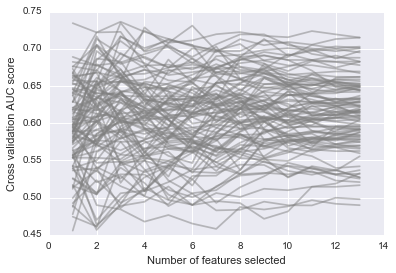

100.0


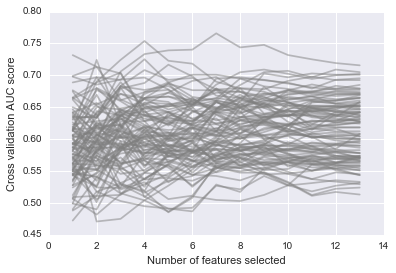

10.0


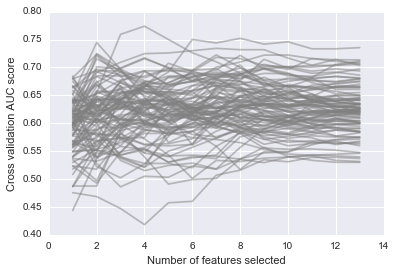

1.0


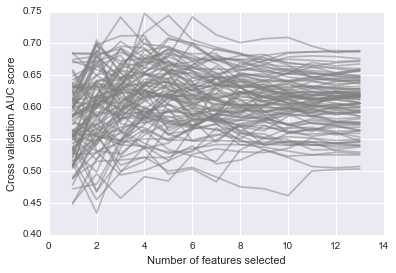

0.1


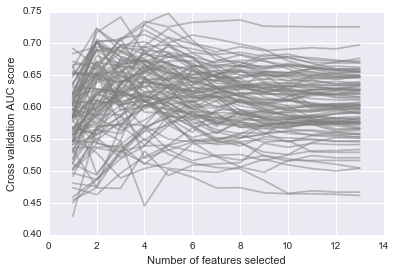

0.01


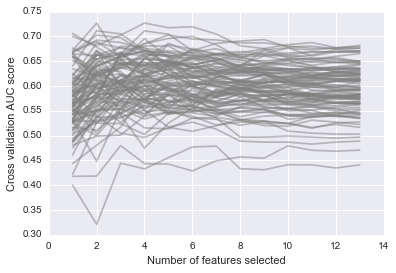

0.001


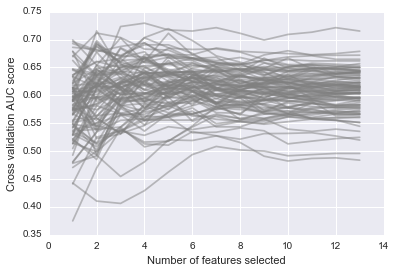

In [9]:
target = 'GDS'
threshold = 0.5
folds = 5

RANK = []
FEAT = []
GRID = []

reg_coeffs = list(10.0**np.arange(3,-4,-1))
for rc in reg_coeffs:
    print rc

    fig,ax = plt.subplots()
    rankings = []
    num_features = []
    grid_scores = []

    for _ in range(100):

        # shuffle the dataframe
        df_shuffled = tnf.shuffle_dataframe(df)

        # select 100 samples from the shuffled dataframe
        # prepare the dataframe for sklearn
        features = ['Age','log10_VL','log10_pVL','CD4','nCD4','CD8','nCD8',
                    'TMHDS','Years_seropositive','Exposure_MSM','Exposure_IDU',
                    'Exposure_heterosexual','Gender_Male']

        X_df, y = tnf.run_preparation_pipeline2(df_shuffled[:100], features, target, threshold)

        # prepare for RFECV ###########
        ridge_model = LogisticRegression(penalty='l2',solver='liblinear',fit_intercept=True,
                                         C=rc, class_weight='balanced', n_jobs=-1)

        rfecv = RFECV(estimator=ridge_model, step=1, cv=5, scoring='roc_auc')
        rfecv.fit(X_df, y)

        rankings.append(rfecv.ranking_)
        num_features.append(rfecv.n_features_)
        grid_scores.append(rfecv.grid_scores_)

        #print("Optimal number of features : %d" % rfecv.n_features_)
        # Plot number of features VS. cross-validation scores

        #plt.figure()
        ax.set_xlabel("Number of features selected")
        ax.set_ylabel("Cross validation AUC score")
        ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='gray', alpha=0.5)

    plt.show()
    
    RANK.append(rankings)
    FEAT.append(num_features)
    GRID.append(grid_scores)

# Plot Feature Selection Data

In [10]:
def get_top_features(rankings):
    rank_mask = [r==1 for r in rankings]
    top_feats = X_df.columns[rank_mask]
    return list(top_feats)

def make_RFE_DF(num_features, rankings, grid_scores):
    RFE_DF = pd.DataFrame()
    RFE_DF['Number of Features'] = num_features
    RFE_DF['Rankings'] = rankings
    RFE_DF['Grid Scores'] = grid_scores
    RFE_DF['Max_Scores'] = RFE_DF['Grid Scores'].apply(max)
    RFE_DF['Top Features'] = RFE_DF['Rankings'].apply(get_top_features)
    return RFE_DF

In [12]:
DF0 = make_RFE_DF(FEAT[0],RANK[0],GRID[0])
DF1 = make_RFE_DF(FEAT[1],RANK[1],GRID[1])
DF2 = make_RFE_DF(FEAT[2],RANK[2],GRID[2])
DF3 = make_RFE_DF(FEAT[3],RANK[3],GRID[3])
DF4 = make_RFE_DF(FEAT[4],RANK[4],GRID[4])
DF5 = make_RFE_DF(FEAT[5],RANK[5],GRID[5])
DF6 = make_RFE_DF(FEAT[6],RANK[6],GRID[6])
alldfs = [DF0, DF1, DF2, DF3, DF4, DF5, DF6]

In [84]:
fm,fs = [],[]
for rfedf in alldfs:
    n =  list(rfedf['Number of Features'])
    print np.mean(n), np.std(n)
    fm.append(np.mean(n))
    fs.append(np.std(n))

5.91 3.92197654251
6.29 3.82699621113
5.83 3.44399477352
4.78 2.72242538924
4.42 2.49471441251
4.23 2.60328638455
4.66 2.92991467453


In [85]:
mm,ms = [],[]
for rfedf in alldfs:
    n =  list(rfedf['Max_Scores'])
    print np.mean(n), np.std(n)
    mm.append(np.mean(n))
    ms.append(np.std(n))

0.650877053965 0.046039404468
0.650781046269 0.0447411571837
0.66254229798 0.0415161451276
0.651028419312 0.0454287739975
0.654096165177 0.0479168241792
0.636071106995 0.0462954668656
0.645709883635 0.0384549813581


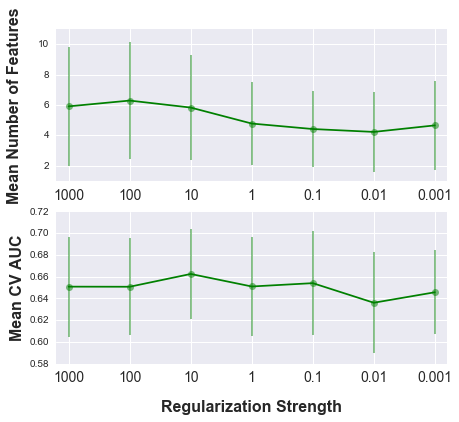

In [119]:
fig,ax=plt.subplots(2,1, figsize=(7,6))

x0 = np.arange(0,len(fm),1)
y0 = fm
ye0 = fs

x1 = np.arange(0,len(mm),1)
y1 = mm
ye1 = ms

#color_options = ['blue','red']
#labels = ['Recursive Feature Selection',
#          'Current viral load and CD4+ T cell count',
#          'Hopkins Dementia Test']

ax[0].errorbar(x0, y0, yerr=ye0, fmt='o', alpha=0.5, color=color_options[i])
ax[0].plot(y0, color=color_options[i])

ax[1].errorbar(x1, y1, yerr=ye1, fmt='o', alpha=0.5, color=color_options[i])
ax[1].plot(y1, color=color_options[i])

# formatting stuff
ax[0].set_ylabel('Mean Number of Features', weight='bold', fontsize=16, labelpad=16)
ax[0].set_xlim([-0.2,6.2])
ax[0].set_xticks(ind)
labels = ['1000', '100', '10', '1', '0.1', '0.01', '0.001']
ax[0].set_xticklabels(labels, fontsize=14)
#ax[0].set_ylim([0,10])
#ax[0].set_yticklabels(np.arange(0,10,1),fontsize=14)

ax[1].set_ylabel('Mean CV AUC', weight='bold', fontsize=16)
ax[1].set_xlim([-0.2,6.2])
ax[1].set_xticks(ind)
labels = ['1000', '100', '10', '1', '0.1', '0.01', '0.001']
ax[1].set_xticklabels(labels, fontsize=14)
#ax[1].set_ylim([0,100])
#ax[1].set_yticklabels(np.arange(0,120,20),fontsize=14)
ax[1].set_xlabel('Regularization Strength', labelpad=15, fontsize=16, weight='bold')

plt.show()

fig.tight_layout()
savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_num_features.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')

# Feature Importance

In [35]:
from collections import Counter

selection_dict = {'Age':[],'log10_VL':[],'log10_pVL':[],'CD4':[],'nCD4':[],
                  'CD8':[],'nCD8':[],'TMHDS':[],'Years_seropositive':[],
                  'Exposure_MSM':[],'Exposure_IDU':[],'Exposure_heterosexual':[],
                  'Gender_Male':[]}

for rfedf in alldfs:
    topf = []
    lofl = list(rfedf['Top Features'])
    for li in lofl:
        topf.extend(li)
    counts_dict = dict(Counter(topf))
    
    selection_dict['Age'].append(counts_dict['Age'])
    selection_dict['log10_VL'].append(counts_dict['log10_VL'])
    selection_dict['log10_pVL'].append(counts_dict['log10_pVL'])
    selection_dict['CD4'].append(counts_dict['CD4'])
    selection_dict['nCD4'].append(counts_dict['nCD4'])
    selection_dict['CD8'].append(counts_dict['CD8'])
    selection_dict['nCD8'].append(counts_dict['nCD8'])
    selection_dict['TMHDS'].append(counts_dict['TMHDS'])
    selection_dict['Years_seropositive'].append(counts_dict['Years_seropositive'])
    selection_dict['Exposure_MSM'].append(counts_dict['Exposure_MSM'])
    selection_dict['Exposure_IDU'].append(counts_dict['Exposure_IDU'])
    selection_dict['Exposure_heterosexual'].append(counts_dict['Exposure_heterosexual'])
    selection_dict['Gender_Male'].append(counts_dict['Gender_Male'])
    
print selection_dict

{'Exposure_heterosexual': [12, 19, 10, 6, 15, 16, 18], 'Exposure_IDU': [14, 17, 10, 6, 9, 21, 20], 'CD4': [90, 97, 99, 98, 96, 88, 91], 'log10_VL': [44, 42, 39, 22, 9, 16, 23], 'CD8': [51, 51, 46, 17, 9, 5, 5], 'Gender_Male': [24, 19, 15, 4, 8, 8, 11], 'nCD8': [50, 45, 48, 16, 9, 11, 14], 'TMHDS': [85, 93, 94, 97, 98, 99, 99], 'Years_seropositive': [51, 58, 53, 55, 58, 48, 56], 'nCD4': [64, 74, 65, 51, 20, 3, 12], 'Exposure_MSM': [16, 18, 14, 7, 5, 9, 12], 'log10_pVL': [27, 29, 25, 26, 34, 50, 62], 'Age': [63, 67, 65, 73, 72, 49, 43]}


In [111]:
select_df = pd.DataFrame(selection_dict)
select_df

,Age,CD4,CD8,Exposure_IDU,Exposure_MSM,Exposure_heterosexual,Gender_Male,TMHDS,Years_seropositive,log10_VL,log10_pVL,nCD4,nCD8
0,63,90,51,14,16,12,24,85,51,44,27,64,50
1,67,97,51,17,18,19,19,93,58,42,29,74,45
2,65,99,46,10,14,10,15,94,53,39,25,65,48
3,73,98,17,6,7,6,4,97,55,22,26,51,16
4,72,96,9,9,5,15,8,98,58,9,34,20,9
5,49,88,5,21,9,16,8,99,48,16,50,3,11
6,43,91,5,20,12,18,11,99,56,23,62,12,14


In [113]:
select_df.iloc[[2,4]]

# age, cd4, tmhds, years, ncd4
# age, cd4, tmhds, years

,Age,CD4,CD8,Exposure_IDU,Exposure_MSM,Exposure_heterosexual,Gender_Male,TMHDS,Years_seropositive,log10_VL,log10_pVL,nCD4,nCD8
2,65,99,46,10,14,10,15,94,53,39,25,65,48
4,72,96,9,9,5,15,8,98,58,9,34,20,9


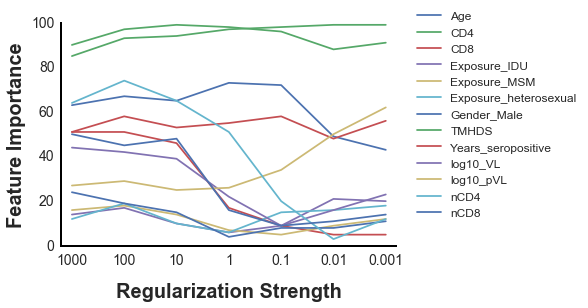

In [120]:
fig,ax = plt.subplots()
select_df.columns
for c in list(select_df.columns):
    ax.plot(select_df[c], label=c)

legend = ax.legend(loc='upper center', shadow=True, fontsize=12,
                   bbox_to_anchor=(1.3, 1.1), fancybox=True)

ax.set_ylabel('Feature Importance', weight='bold', fontsize=20)
ax.set_xlim([-0.2,6.2])
ax.set_xticks(ind)
labels = ['1000', '100', '10', '1', '0.1', '0.01', '0.001']
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim([0,100])
ax.set_yticklabels(np.arange(0,120,20),fontsize=14)
ax.set_xlabel('Regularization Strength', labelpad=15, fontsize=20, weight='bold')

# formatting colors and axes
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

plt.show()

fig.tight_layout()
savepath = '/Users/Greg/Projects/HIV_Neuro_NGS/Figures/clin_feature_importance.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')